# Chevron Track Rice Datathon 2025

Objective: Predicting Vehicle Inventory for 2025

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [62]:
training = pd.read_excel('training.xlsx')
scoring = pd.read_excel("scoring.xlsx")
californiaUtilityData = pd.read_excel("cailutility2.xlsx", sheet_name=2)

In [63]:
californiaUtilityData = californiaUtilityData.rename(columns={"year": "modelYear"})

# Exploratory Data Analysis

In [64]:
#Get the initial statistics of the training dataset
training.describe()

,Date,Model Year,Vehicle Population
count,41053.000000,40450.000000,41053.000000
mean,2020.985312,2002.075871,3463.929506
std,1.398470,13.462658,18833.839302
min,2019.000000,1975.000000,1.000000
25%,2020.000000,1991.000000,5.000000
50%,2021.000000,2003.000000,39.000000
75%,2022.000000,2014.000000,390.000000
max,2023.000000,2026.000000,395883.000000


In [65]:
print(training.isnull().sum())   

Date                                                   0
Vehicle Category                                       0
GVWR Class                                             0
Fuel Type                                              0
Model Year                                           603
Fuel Technology                                        0
Electric Mile Range                                    0
Number of Vehicles Registered at the Same Address      0
Region                                                 0
Vehicle Population                                     0
dtype: int64


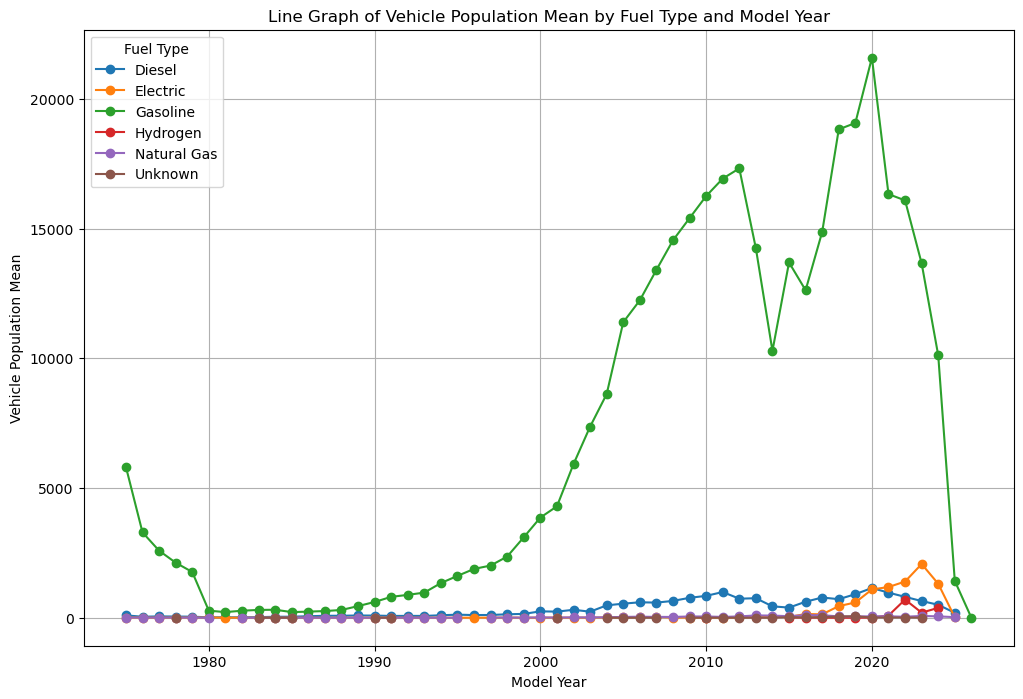

In [66]:
grouped_data = training.groupby(['Fuel Type', 'Model Year'])['Vehicle Population'].mean().unstack()

plt.figure(figsize=(12, 8))
for fuel_type in grouped_data.index:
    plt.plot(grouped_data.columns, grouped_data.loc[fuel_type], marker='o', label=fuel_type)

plt.title("Line Graph of Vehicle Population Mean by Fuel Type and Model Year")
plt.xlabel("Model Year")
plt.ylabel("Vehicle Population Mean")
plt.legend(title='Fuel Type')
plt.grid(True)
plt.show()

A Kernel Density Estimate (KDE) plot is a smooth representation of the data's distribution.

The peak of the curve, represents the value with the highest likelhood of occuring.

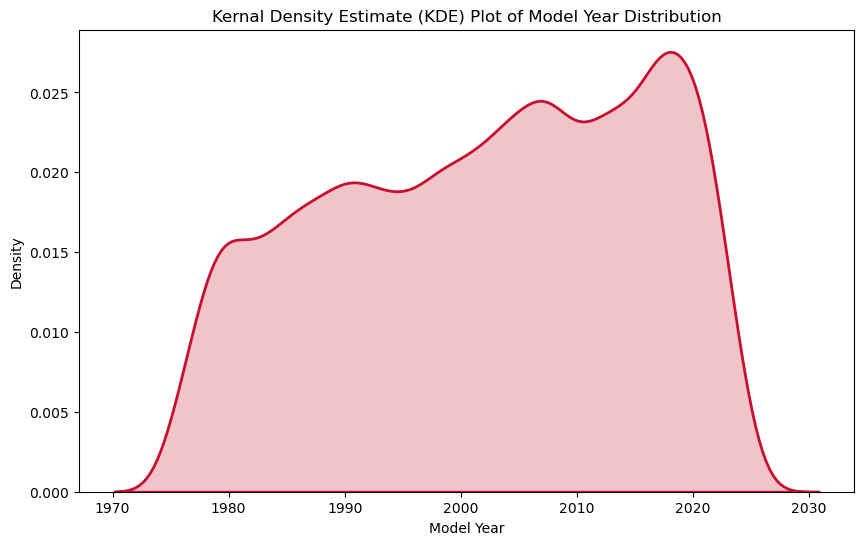

In [67]:
plt.figure(figsize=(10, 6))
sns.kdeplot(training['Model Year'], fill=True, color="#C8102E", linewidth=2)
plt.xlabel("Model Year")
plt.ylabel("Density")
plt.title("Kernal Density Estimate (KDE) Plot of Model Year Distribution")
plt.show()

Our KDE plot reveals a wide distribution, suggesting that the data does not have a concentration of vehicles from a single model year. Notably, the plot shows an increasing skew toward newer model years. This is expected, as vehicles tend to have a finite lifespan; over time, they are more likely to be involved in accidents, experience significant mechanical failures, or wear out, which could shorten their lifespan.

# Data Wrangling: Preprocessing

Training Data Preprocessing

In [68]:
# Renaming columns to short-hand without spaces
training = training.rename(columns={
    'Date': 'year',
    'Vehicle Category': 'vehicleCategory',
    'GVWR Class': 'gvwrClass',
    'Fuel Type': 'fuelType',
    "Model Year": "modelYear",
    "Fuel Technology": "fuelTechnology",
    "Electric Mile Range": "electricMileRange",
    "Number of Vehicles Registered at the Same Address": "numVehiclesReg",
})

# Dropping column 'Region' as all values correspond to 'Statewide'
training = training.drop(columns=['Region'])

# Update missing values in Model Year to use mode from Fuel Type, Fuel Technology subcategories
mode_per_group = training.groupby(["fuelType", "fuelTechnology"])['modelYear'].transform(lambda x: pd.Series.mode(x).iloc[0] if not x.mode().empty else x)
training['modelYear'] = training['modelYear'].fillna(mode_per_group)

# Update unknown values in Electric Mile Range to use mode from Date, Vehicle Category, Fuel Type, Fuel Technology subcategories
mode_electricMileRange = training.groupby(["year", "vehicleCategory", "fuelType", "fuelTechnology"])['electricMileRange'].transform(lambda x: pd.Series.mode(x).iloc[0] if not x.mode().empty else x)
training['electricMileRange'] = training['electricMileRange'].where(training['electricMileRange'] != 'Unknown', mode_electricMileRange)

# Apply one-hot encoding to GVWR Class, Vehicle Category, Fuel Type, Fuel Technology, Electric Mile Range
training = pd.get_dummies(training,
                            columns=["gvwrClass", "vehicleCategory", "fuelType", "fuelTechnology", "electricMileRange"],
                            prefix=["gvwrClass", "vehicleCategory", "fuelType", "fuelTech", "electricMileRange"],
                            prefix_sep="_")

# Feature synthesis with extracting vehicle age from year of indutry and model year
training['vehicleAge'] = training['year'] - training['modelYear']

# Create ordinal encoder from numVehiclesReg
from sklearn.preprocessing import OrdinalEncoder
training['numVehiclesReg'] = training['numVehiclesReg'].astype(str)
ordinal_encoder = OrdinalEncoder(categories=[['Unknown', '1', '2', '3', '≥4']])
training['numVehiclesRegEncoded'] = ordinal_encoder.fit_transform(training[['numVehiclesReg']])
training = training.drop(columns=['numVehiclesReg'])

The data was preprocessed in the following ways:
1. The 'Region' Column was removed as it was a single variable
2. The unknowns in 'Model Year' and 'Electric Mile Range' were reduced by calculating the mode of vehicles with the same corresponding features. (E.g. mode of the vehicles with the same Fuel Type and Fuel Technology was used to impute the data)
3. Ordinal encoder was used for the 'Number of Registered Vehicles in the Same Address'
4. One Hot Encoder was used for 'GVWR Class', 'Vehicle Category', 'Fuel Type', 'Fuel Technology' and 'Electric Mile Range'
5. A new column 'Vehicle Age' was added by taking the difference of the 'Date' and 'Model Year'

In [69]:
training

,year,modelYear,Vehicle Population,gvwrClass_1,gvwrClass_2,gvwrClass_3,gvwrClass_4,gvwrClass_5,gvwrClass_6,gvwrClass_7,...,fuelTech_ICE,fuelTech_PHEV,electricMileRange_0 to 50 miles,electricMileRange_101 to 150 miles,electricMileRange_51 to 100 miles,electricMileRange_>150 miles,electricMileRange_Not Applicable,electricMileRange_Unknown,vehicleAge,numVehiclesRegEncoded
0,2019,2020.0,395883,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,-1.0,4.0
1,2020,2020.0,370954,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,0.0,1.0
2,2021,2020.0,349406,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,1.0,1.0
3,2019,2019.0,348475,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,0.0,4.0
4,2019,2018.0,333296,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,1.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41048,2019,1983.0,1,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,36.0,1.0
41049,2019,1980.0,1,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,39.0,2.0
41050,2019,1978.0,1,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,41.0,3.0
41051,2019,1976.0,1,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,43.0,2.0


In [70]:
trainingCali = pd.merge(training, californiaUtilityData, on="modelYear", how="left")

Training Data with Additional California Data Features

In [71]:
trainingCali

,year,modelYear,Vehicle Population,gvwrClass_1,gvwrClass_2,gvwrClass_3,gvwrClass_4,gvwrClass_5,gvwrClass_6,gvwrClass_7,...,electricMileRange_51 to 100 miles,electricMileRange_>150 miles,electricMileRange_Not Applicable,electricMileRange_Unknown,vehicleAge,numVehiclesRegEncoded,Average of avgPriceGasolineUnleadedRegular,Average of avgGasPerThermUSD,Average of avgElecKWHUSD,Average of avgLowSulfurDieselUsdPerGallon
0,2019,2020.0,395883,False,False,False,False,False,False,False,...,False,False,True,False,-1.0,4.0,3.118000,1.615583,0.234917,3.118000
1,2020,2020.0,370954,False,False,False,False,False,False,False,...,False,False,True,False,0.0,1.0,3.118000,1.615583,0.234917,3.118000
2,2021,2020.0,349406,False,False,False,False,False,False,False,...,False,False,True,False,1.0,1.0,3.118000,1.615583,0.234917,3.118000
3,2019,2019.0,348475,False,False,False,False,False,False,False,...,False,False,True,False,0.0,4.0,3.705417,1.486333,0.217333,3.705417
4,2019,2018.0,333296,False,False,False,False,False,False,False,...,False,False,True,False,1.0,4.0,3.641833,1.449750,0.209750,3.641833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41048,2019,1983.0,1,False,False,False,False,False,False,False,...,False,False,True,False,36.0,1.0,1.291583,0.475667,0.076333,NaN
41049,2019,1980.0,1,False,False,False,False,False,False,False,...,False,False,True,False,39.0,2.0,1.309833,0.453833,0.067167,NaN
41050,2019,1978.0,1,False,False,False,False,False,False,False,...,False,False,True,False,41.0,3.0,0.716917,0.203000,0.041000,NaN
41051,2019,1976.0,1,False,False,False,False,False,False,False,...,False,False,True,False,43.0,2.0,NaN,NaN,NaN,NaN


We added additional features to help generalize the model. These features include gas, diesel, natural gas and electricity prices.

Scoring Data Preprocessing

In [72]:
# Renaming columns to short-hand without spaces
scoring = scoring.rename(columns={
    'Date': 'year',
    'Vehicle Category': 'vehicleCategory',
    'GVWR Class': 'gvwrClass',
    'Fuel Type': 'fuelType',
    "Model Year": "modelYear",
    "Fuel Technology": "fuelTechnology",
    "Electric Mile Range": "electricMileRange",
    "Number of Vehicles Registered at the Same Address": "numVehiclesReg",
})

# Dropping column 'Region' as all values correspond to 'Statewide'
scoring = scoring.drop(columns=['Region'])

# Update missing values in Model Year to use mode from Fuel Type, Fuel Technology subcategories
mode_per_group_scoring = scoring.groupby(["fuelType", "fuelTechnology"])['modelYear'].transform(lambda x: pd.Series.mode(x).iloc[0] if not x.mode().empty else x)
scoring['modelYear'] = scoring['modelYear'].fillna(mode_per_group_scoring)

# Update unknown values in Electric Mile Range to use mode from Date, Vehicle Category, Fuel Type, Fuel Technology subcategories
mode_electricMileRange_scoring = scoring.groupby(["year", "vehicleCategory", "fuelType", "fuelTechnology"])['electricMileRange'].transform(lambda x: pd.Series.mode(x).iloc[0] if not x.mode().empty else x)
scoring['electricMileRange'] = scoring['electricMileRange'].where(scoring['electricMileRange'] != 'Unknown', mode_electricMileRange_scoring)

# Apply one-hot encoding to GVWR Class, Vehicle Category, Fuel Type, Fuel Technology, Electric Mile Range
scoring = pd.get_dummies(scoring,
                            columns=["gvwrClass", "vehicleCategory", "fuelType", "fuelTechnology", "electricMileRange"],
                            prefix=["gvwrClass", "vehicleCategory", "fuelType", "fuelTech", "electricMileRange"],
                            prefix_sep="_")
#training = pd.merge(training, californiaUtilityData, on="modelYear", how="left")

# Feature synthesis with extracting vehicle age from year of indutry and model year
scoring['vehicleAge'] = scoring['year'] - scoring['modelYear']

# Create ordinal encoder from numVehiclesReg
from sklearn.preprocessing import OrdinalEncoder
scoring['numVehiclesReg'] = scoring['numVehiclesReg'].astype(str)
ordinal_encoder = OrdinalEncoder(categories=[['Unknown', '1', '2', '3', '≥4']])
scoring['numVehiclesRegEncoded'] = ordinal_encoder.fit_transform(scoring[['numVehiclesReg']])
scoring = scoring.drop(columns=['numVehiclesReg'])

if 'fuelType_Unknown' in training.columns and 'fuelType_Unknown' not in scoring.columns:
    scoring['fuelType_Unknown'] = 0

# Align ordering to fit training columns
scoring = scoring[training.columns]

y_scoring_actual = scoring['Vehicle Population']
scoring = scoring.drop(columns=['Vehicle Population'])

In [73]:
scoringCali = pd.merge(scoring, californiaUtilityData, on="modelYear", how="left")

Preprocessing was repeated to the scoring data

In [74]:
scoring

,year,modelYear,gvwrClass_1,gvwrClass_2,gvwrClass_3,gvwrClass_4,gvwrClass_5,gvwrClass_6,gvwrClass_7,gvwrClass_8,...,fuelTech_ICE,fuelTech_PHEV,electricMileRange_0 to 50 miles,electricMileRange_101 to 150 miles,electricMileRange_51 to 100 miles,electricMileRange_>150 miles,electricMileRange_Not Applicable,electricMileRange_Unknown,vehicleAge,numVehiclesRegEncoded
0,2024,2020.0,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,4.0,4.0
1,2024,2021.0,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,3.0,4.0
2,2024,2022.0,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,2.0,4.0
3,2024,2024.0,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,0.0,4.0
4,2024,2023.0,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,1.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7541,2024,1989.0,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,35.0,3.0
7542,2024,1988.0,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,36.0,2.0
7543,2024,1988.0,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,36.0,3.0
7544,2024,1987.0,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,37.0,2.0


# Model Training and Testing Without California Dataset

We wanted to compare the performance of our model on the training data with and without the additional California data.

We first tested 3 different models on the training data without the California data:
- Ridge Regression
- Lasso Regression
- Light GBM

The performance was compared and the best performing model was used on the training data with the additional California data

In [75]:
from bayes_opt import BayesianOptimization
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [76]:
#Train/Test Split on Training Data
X = training.drop(columns=["Vehicle Population"])  # Features
y = training["Vehicle Population"]  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)

Ridge Regression

In [77]:
from sklearn.linear_model import Ridge

# Train a Ridge Regression model
ridge_model = Ridge(alpha=1.0)  # Regularization strength

ridge_model.fit(X_train, y_train)

# Make predictions
y_pred_ridge = ridge_model.predict(X_test)

# Calculate RMSE
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
print(f"Ridge Regression RMSE: {rmse_ridge}")

mae = mean_absolute_error(y_test, y_pred_ridge)
print(f"Mean Absolute Error: {mae}")
r2 = r2_score(y_test, y_pred_ridge)
print(f"R-squared: {r2}")


Ridge Regression RMSE: 17338.76123485272
Mean Absolute Error: 7245.464190262569
R-squared: 0.17555496762677392


Lasso Regression

In [78]:
from sklearn.linear_model import Lasso

lasso_model = Lasso(alpha=0.1)

lasso_model.fit(X_train, y_train)

y_pred_lasso = lasso_model.predict(X_test)

rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
print(f"Lasso Regression RMSE: {rmse_lasso}")

mae = mean_absolute_error(y_test, y_pred_lasso)
print(f"Mean Absolute Error: {mae}")

r2 = r2_score(y_test, y_pred_lasso)
print(f"R-squared: {r2}")



Lasso Regression RMSE: 17338.924100665336
Mean Absolute Error: 7246.743593042548
R-squared: 0.17553947926068292


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.369e+12, tolerance: 1.157e+09
  model = cd_fast.enet_coordinate_descent(


LightGBM

Bayesian Hyperparameter Optimization 

In [79]:
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test)

# Define the optimization function for Bayesian Optimization
def lgb_eval(num_leaves, max_depth, learning_rate, n_estimators, min_child_samples, subsample, colsample_bytree, lambda_l1, lambda_l2, log_max_bin, reg_alpha,reg_lambda):
    # Set the LightGBM parameters
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': int(num_leaves),
        'max_depth': int(max_depth),
        'learning_rate': learning_rate,
        'n_estimators': int(n_estimators),
        'min_child_samples': int(min_child_samples),
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'lambda_l1': lambda_l1,
        'lambda_l2': lambda_l2,
        'feature_pre_filter': False, # Disable feature pre-filtering
        'log_max_bin': log_max_bin,
        'reg_alpha': reg_alpha,
        'reg_lambda': reg_lambda
    }
    
    # Train the model without 'verbose' argument
    model = lgb.train(params, train_data, valid_sets=[valid_data],)
    
    # Predict and calculate RMSE
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Return the negative RMSE (since we are maximizing)
    return -rmse


# Set up the Bayesian Optimizer with wider ranges
optimizer = BayesianOptimization(
    f=lgb_eval, 
    pbounds={
        'num_leaves': (10, 200),  # Increased range
        'max_depth': (3, 25),      # Increased range
        'learning_rate': (0.001, 0.1),  # Increased range
        'n_estimators': (30, 500),  # Increased range
        'min_child_samples': (1, 100),  # Increased range
        'subsample': (0.4, 1.0),  # Increased range
        'colsample_bytree': (0.4, 1.0),  # Increased range
        'lambda_l1': (1e-6, 1e-2),  # Increased range
        'lambda_l2': (1e-6, 1e-2),  # Increased range
        'log_max_bin': (5,10), # Increased range
        'reg_alpha': (0.01,0.1),
        'reg_lambda': (0.1,0.5)

    },
    random_state=27
)



In [80]:
'''
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': int(81.94562010166663),
    'max_depth': int(10.32559568840523),
    'learning_rate': 0.3,
    'n_estimators': int(117.14689484673896),
    'min_child_samples': int(9.787194938765415),
    'subsample': 1.0,
    'colsample_bytree': 1.0,
    'lambda_l1': 0.01,
    'lambda_l2': 0.01,
    'feature_pre_filter': False 
}
'''

bayes_2_params = {'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt', 
    'colsample_bytree': 1.0, 
    'lambda_l1': 0.01, 
    'lambda_l2': 0.01, 
    'learning_rate': 0.1, 
    'log_max_bin': 5.6680313827830195, 
    'max_depth': 14.946890466564938, 
    'min_child_samples': 23.90909213595021, 
    'n_estimators': 370.95179400495664, 
    'num_leaves': 173.00952498196241, 
    'reg_alpha': 0.01, 
    'reg_lambda': 0.1, 
    'subsample': 0.4}

bayes_2_params['n_estimators'] = int(bayes_2_params['n_estimators'])
bayes_2_params['max_depth'] = int(bayes_2_params['max_depth'])
bayes_2_params['min_child_samples'] = int(bayes_2_params['min_child_samples'])
bayes_2_params['num_leaves'] = int(bayes_2_params['num_leaves'])

best_params =  {'n_estimators': 484, 'num_leaves': 101, 'min_child_samples': 3, 'learning_rate': 0.028786855755827394, 'log_max_bin': 8, 'colsample_bytree': 0.989521951242629, 'reg_alpha': 0.02465352850408109, 'reg_lambda': 0.3846632019512515}

best_params['n_estimators'] = int(best_params['n_estimators'])
#best_params['max_depth'] = int(best_params['max_depth'])
best_params['min_child_samples'] = int(best_params['min_child_samples'])
best_params['num_leaves'] = int(best_params['num_leaves'])



model = lgb.train(best_params, 
                  train_data, 
                  valid_sets=[valid_data],  
                  valid_names=["validation"],  
                  num_boost_round=1000,
                  )

y_pred = model.predict(X_test, num_iteration=model.best_iteration)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")

mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

c:\Users\Admin\anaconda3\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: log_max_bin
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: log_max_bin
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 190
[LightGBM] [Info] Number of data points in the train set: 32842, number of used features: 43
[LightGBM] [Warning] Unknown parameter: log_max_bin
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 3489.914682
RMSE: 1561.6487988425888
Mean Absolute Error: 351.3094090451149
R-squared: 0.9933120608007077
Mean Squared Error: 2438746.9709265004


In [81]:
y_scoring_pred = model.predict(scoring)

rmse = np.sqrt(mean_squared_error(y_scoring_actual, y_scoring_pred))
print(f"RMSE: {rmse}")

mae = mean_absolute_error(y_scoring_actual, y_scoring_pred)
print(f"Mean Absolute Error: {mae}")

r2 = r2_score(y_scoring_actual, y_scoring_pred)
print(f"R-squared: {r2}")




RMSE: 3811.2227628686223
Mean Absolute Error: 624.1736495476075
R-squared: 0.961668465371838


The lightGBM model performs significantly better than the other models. Therefore, we chose the lightGBM model for further analysis into feature importance and continued with it for the modeling the training data with the additional California data features

In [82]:
submission = pd.DataFrame(y_scoring_pred)
submission.to_excel("Submission.xlsx", index=False)

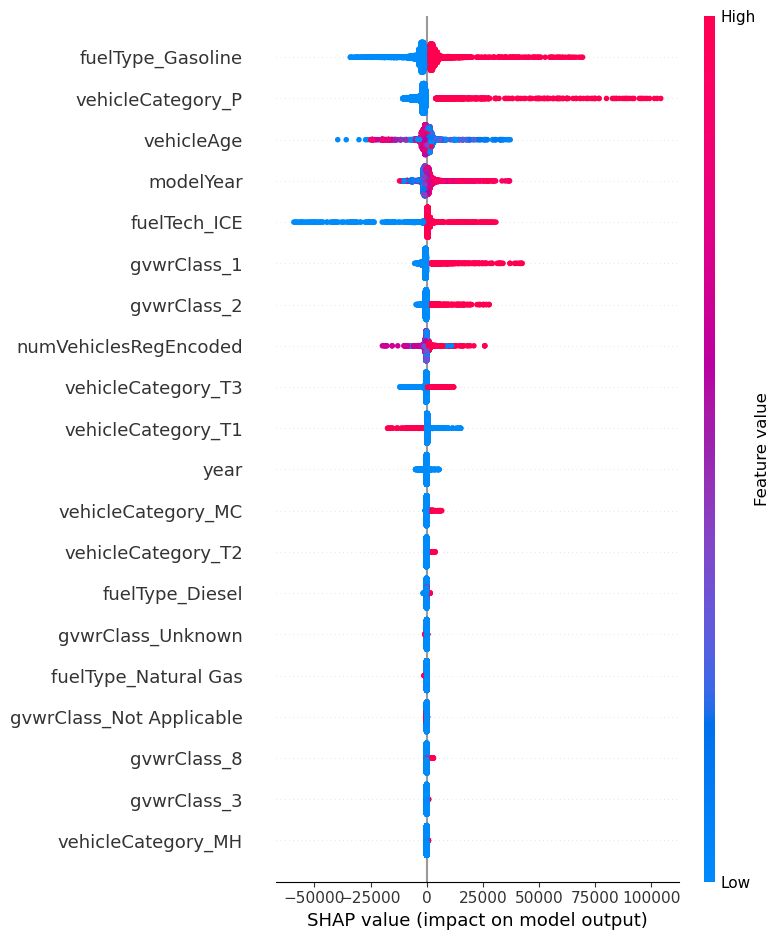

In [83]:
import shap
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(scoring)
shap.summary_plot(shap_values, scoring)

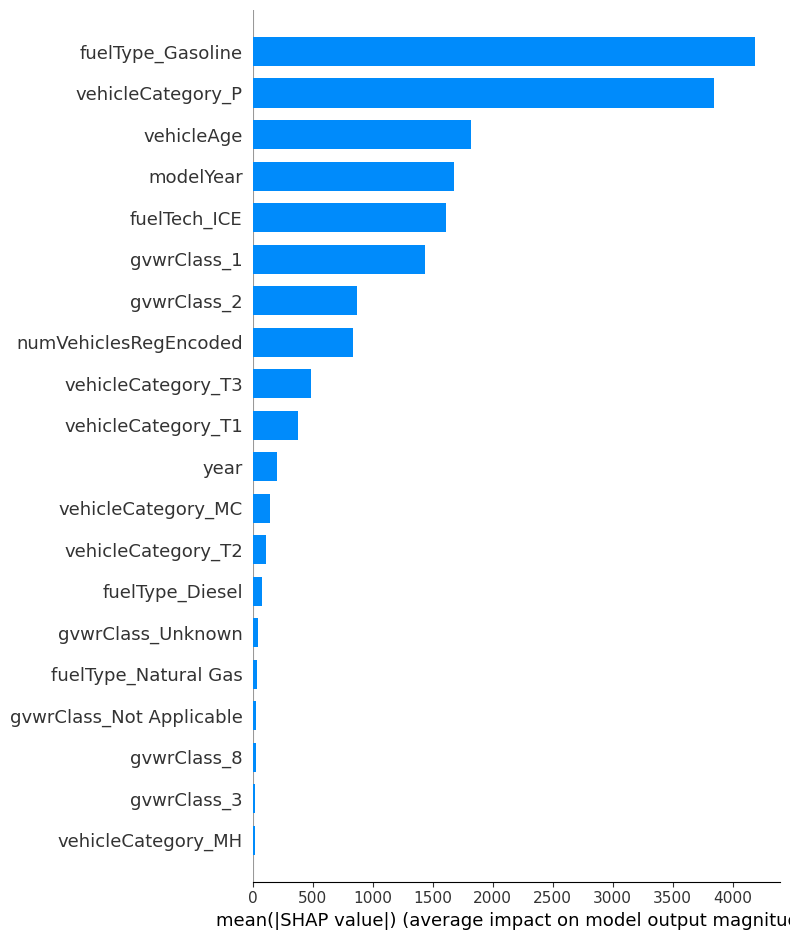

In [84]:
# Plot feature importance using the mean absolute SHAP value per feature
shap.summary_plot(shap_values, scoring, plot_type="bar")


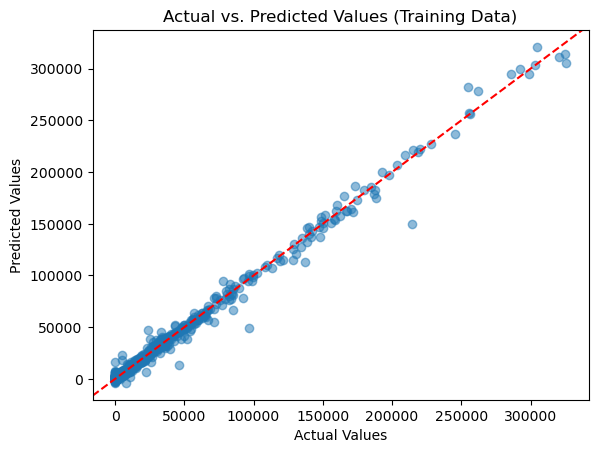

In [85]:
import matplotlib.pyplot as plt
# Training  Data
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values (Training Data)")
plt.axline((0, 0), slope=1, color='red', linestyle='dashed') 
plt.show()


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

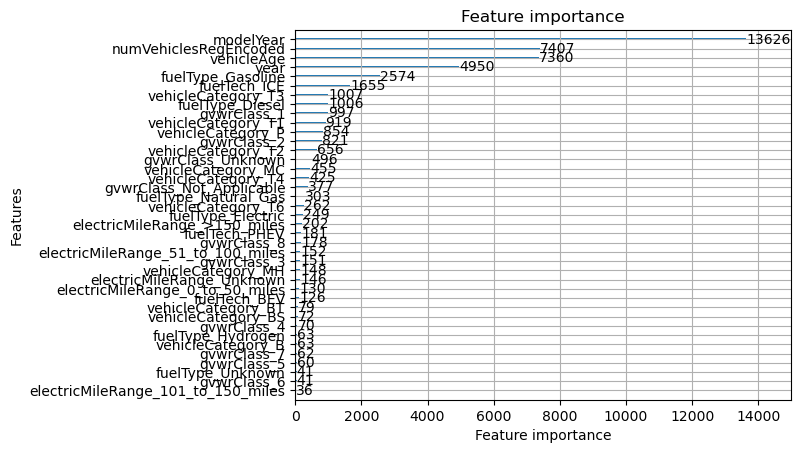

In [86]:
lgb.plot_importance(model)


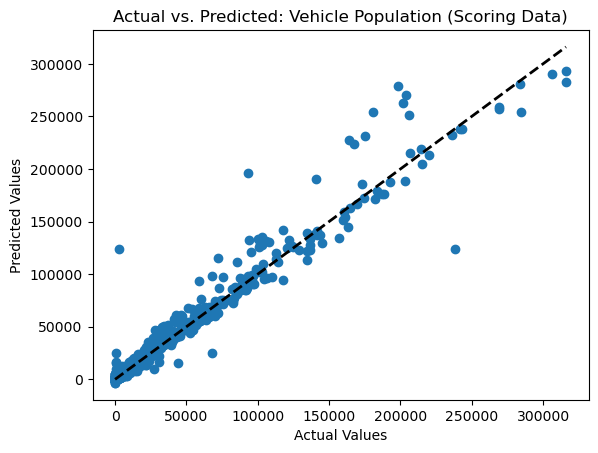

In [87]:
# Scoring Data
plt.scatter(y_scoring_actual, y_scoring_pred)
plt.plot([min(y_scoring_actual), max(y_scoring_actual)],
         [min(y_scoring_actual), max(y_scoring_actual)], 'k--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted: Vehicle Population (Scoring Data)')
plt.show()


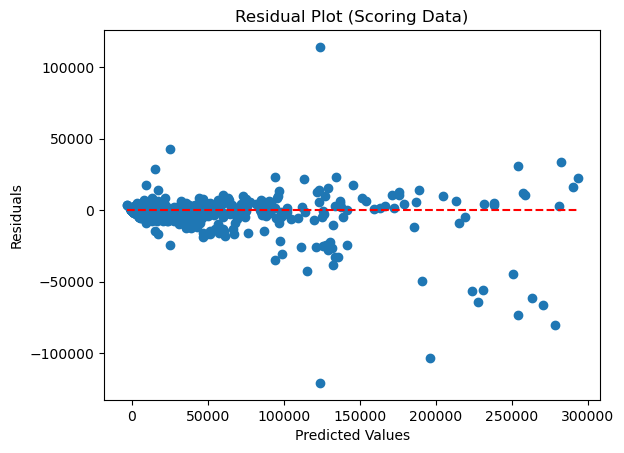

In [88]:
residuals = y_scoring_actual - y_scoring_pred

plt.scatter(y_scoring_pred, residuals)
plt.hlines(y=0, xmin=min(y_scoring_pred), xmax=max(y_scoring_pred), colors='r', linestyles='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot (Scoring Data)')
plt.show()


c:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


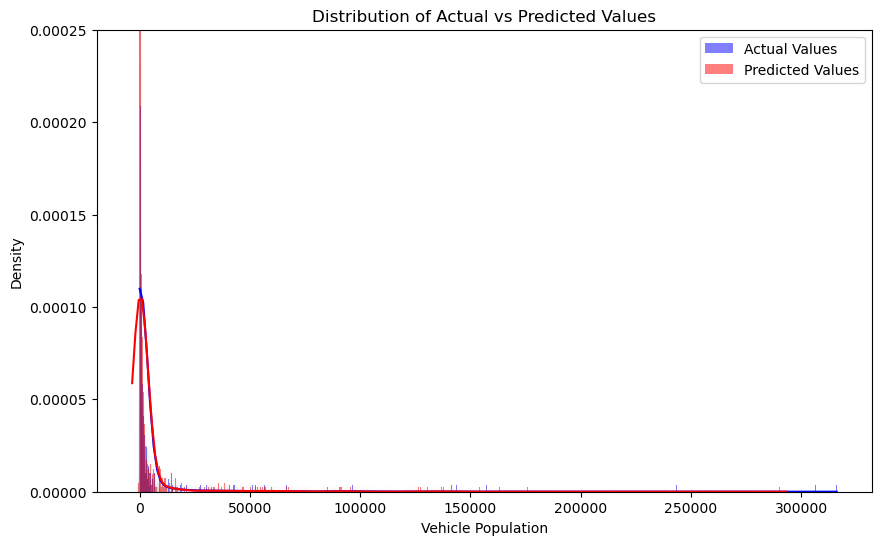

In [89]:
plt.figure(figsize=(10, 6))
sns.histplot(y_scoring_actual, color='blue', kde=True, label='Actual Values', stat='density')
sns.histplot(y_scoring_pred, color='red', kde=True, label='Predicted Values', stat='density')
plt.legend()
plt.title('Distribution of Actual vs Predicted Values')
plt.ylim(0, 0.00025)
plt.show()


# Modelling with California Data Included

In [90]:
X = trainingCali.drop(columns=["Vehicle Population"])  # Features
y = trainingCali["Vehicle Population"]  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test)


In [91]:
cali_model = lgb.train(best_params, 
                  train_data, 
                  valid_sets=[valid_data],  
                  valid_names=["validation"],  
                  num_boost_round=1000,
                  )


y_pred_cali = cali_model.predict(X_test, num_iteration=cali_model.best_iteration)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_cali))
print(f"RMSE: {rmse}")

mae = mean_absolute_error(y_test, y_pred_cali)
print(f"Mean Absolute Error: {mae}")

r2 = r2_score(y_test, y_pred_cali)
print(f"R-squared: {r2}")



c:\Users\Admin\anaconda3\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: log_max_bin
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: log_max_bin
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 32842, number of used features: 47
[LightGBM] [Warning] Unknown parameter: log_max_bin
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 3489.914682
RMSE: 1954.9969818874115
Mean Absolute Error: 379.9861288049386
R-squared: 0.9895186371526862


In [92]:
y_scoring_pred_cali = cali_model.predict(scoringCali)

rmse = np.sqrt(mean_squared_error(y_scoring_actual, y_scoring_pred_cali))
print(f"RMSE: {rmse}")

mae = mean_absolute_error(y_scoring_actual, y_scoring_pred_cali)
print(f"Mean Absolute Error: {mae}")

r2 = r2_score(y_scoring_actual, y_scoring_pred_cali)
print(f"R-squared: {r2}")


RMSE: 5031.895740877013
Mean Absolute Error: 735.1151002813465
R-squared: 0.9331824099351906


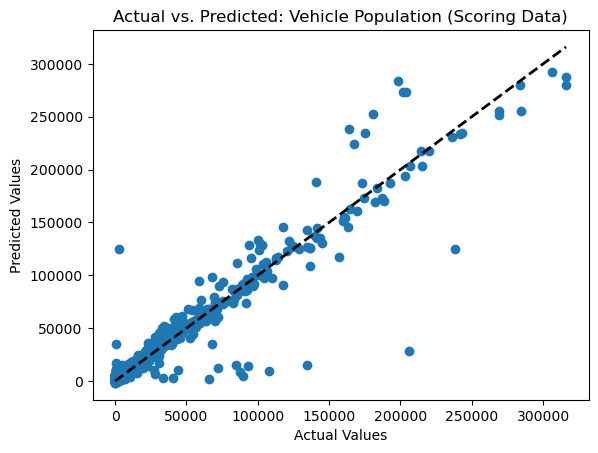

In [93]:
plt.scatter(y_scoring_actual, y_scoring_pred_cali)
plt.plot([min(y_scoring_actual), max(y_scoring_actual)],
         [min(y_scoring_actual), max(y_scoring_actual)], 'k--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted: Vehicle Population (Scoring Data)')
plt.show()

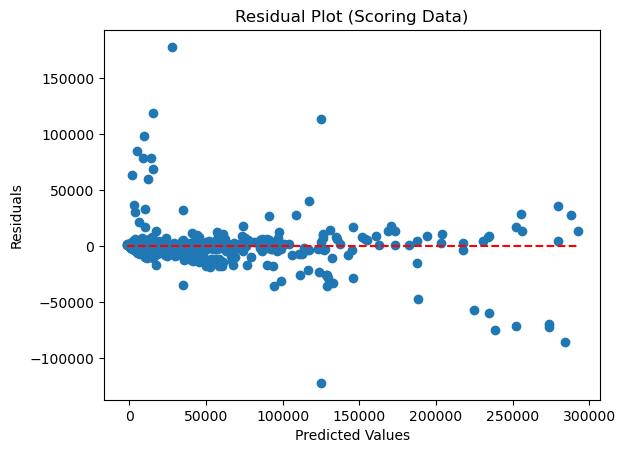

In [94]:
residuals = y_scoring_actual - y_scoring_pred_cali

plt.scatter(y_scoring_pred_cali, residuals)
plt.hlines(y=0, xmin=min(y_scoring_pred_cali), xmax=max(y_scoring_pred_cali), colors='r', linestyles='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot (Scoring Data)')
plt.show()

c:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


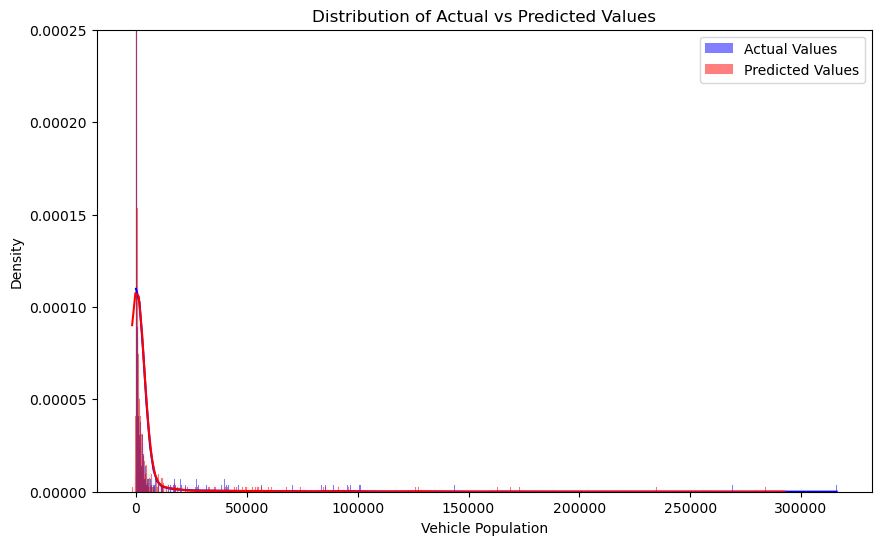

In [95]:
plt.figure(figsize=(10, 6))
sns.histplot(y_scoring_actual, color='blue', kde=True, label='Actual Values', stat='density')
sns.histplot(y_scoring_pred_cali, color='red', kde=True, label='Predicted Values', stat='density')
plt.legend()
plt.title('Distribution of Actual vs Predicted Values')
plt.ylim(0, 0.00025)
plt.show()



On average, the lightgbm model's predictions deviate from the true values by about 3811 units RMSE without the California external data and approximately 5031 units RMSE with the Califorina data.The lower the RMSE, the better the model, since it indicates less error in the predictions. 

96.17% and 93.32% of the variance in the dependent variable can be explained by the lightgbm models without and with the California data respectively. This suggests a very good fit since a value close to 1 indicates that the models are performing well.

Overall, without the California data included the model performed better, however we feel including the historical utility price data helps our model be more generalizable.

In [96]:
submission_cali = pd.DataFrame(y_scoring_pred_cali)
submission_cali.to_excel("Submission_Cali.xlsx", index=False)

California Dataset source: https://fred.stlouisfed.org/series/APUS49B74714